# Using the Variational Hamiltonian Ansatz on the Hubbard model

The Hubbard model is a simplification of correlated electrons. Despite its simplistic structure, the Hubbard model is able to capture some interesting physics, such as the transition of a solid from a conducting to insulating state and some superconducting effects (though I don't yet understand any of this). 

In this notebook, we'll briefly describe the Hubbard model and then try to use the VHA to solve it. 

$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 \rvert}$
$\newcommand{\braket}[1]{\langle #1 \rangle}$

**Update 1**: I started by defining my own classes/functions for creation/annihilation operators, the Jordan-Wigner transform, the square lattice for the Hubbard Hamiltonian, the Hubbard Hamiltonian's matrix representation, and the Variational Hamiltonian Ansatz (VHA). As expected, my code and computer's RAM wasn't enough to work with anything more than a 2x2 square lattice (which has 8 qubits, so exists 256-dimensional Hilbert space). What did surprise me was how much more efficient OpenFermion was, because when I tried it when SSHing onto a Google Cloud computer, I was able to quickly solve the ground state of up to a 2x10 square lattice Hubbard Hamiltonian. Most of the functions/classes I defined are still available in the tools/ folder if you want to take a look. 

In [1]:
import numpy as np
import scipy.linalg
import scipy.optimize 

from tools.utils import * 
tol = 0.005 # Tolerance for elementwise equality of matrices

<a id="hubbard-ham"></a>
### Defining the Hubbard Hamiltonian 

The Hubbard Hamiltonian: 
$$ H = -t \sum_{\braket{j, k}, \sigma} \Big( c^\dagger_{j\sigma} c_{k\sigma} + c^\dagger_{k \sigma} c_{j \sigma} \Big) + U \sum_j n_{j \uparrow} n_{j \downarrow} - \mu \sum_j \Big(n_{j\uparrow} + n_{j\downarrow} \Big) $$

The first term is kinetic energy, a fermion moving from one site to another. The symbol $\braket{j, k}$ implies iterating over sites that are adjacent. 

The second term is interaction energy, additional energy for a doubly-occupied site. 

The third term is chemical potential, which controls the filling. 

### 2D Hubbard Hamiltonian on a Square Lattice 

We'll use OpenFermion's `HubbardSquareLattice` class to define our lattice. OpenFermion has a simpler function `fermi_hubbard()` to create a `FermionOperator` to describe our system, but this doesn't give us access to the specific hopping terms in the Hamiltonian (the terms in the first summation above), which we'll need for the Variational Hamiltonian Ansatz. 

In [60]:
from openfermion.utils import HubbardSquareLattice
# HubbardSquareLattice parameters
x_n = 2
y_n = 2
n_dofs = 1 # 1 degree of freedom for spin, this might be wrong. Having only one dof means ordered=False. 
periodic = 0 # Not sure what this is, periodic boundary conditions?
spinless = 0 # Has spin

lattice = HubbardSquareLattice(x_n, y_n, n_dofs=n_dofs, periodic=periodic, spinless=spinless)

Now, we'll create a `FermiHubbardModel` instance by passing it our `HubbardSquareLattice` instance defined above. 

To get the `FermionOperator` instance, we need to call `FermiHubbardModel.hamiltonian()`. The [documentation](https://openfermion.readthedocs.io/en/latest/openfermion.html#openfermion.hamiltonians.FermiHubbardModel) isn't that great here, but the [source code](https://github.com/quantumlib/OpenFermion/blob/master/src/openfermion/hamiltonians/_general_hubbard.py) indicates we do indeed get a `FermionOperator` instance which we'll need for calculating ground state, etc. 

We can't just pass an integer for $t$, $U$, or $\mu$ in this class. Instead, we have to specify the *specific* coefficient for each pair and edge type ($t_{ij}^{\textrm{horizontal neighbor}}$). This will be useful later on, I think, because [1506.05135](https://arxiv.org/abs/1506.05135) says we'll need the indices for different values during adiabatic evolution. 

In [64]:
from openfermion.hamiltonians import FermiHubbardModel
from openfermion.utils import SpinPairs
tunneling = [('neighbor', (0, 0), 1.)] # Not sure if this is right
interaction = [('onsite', (0, 0), 2., SpinPairs.DIFF)] # Not sure if this is right
potential = [(0, 1.)]
mag_field = 0. 
particle_hole_sym = False # Not sure if this is right

In [65]:
hubbard = FermiHubbardModel(lattice , tunneling_parameters=tunneling, interaction_parameters=interaction, 
                            potential_parameters=potential, magnetic_field=mag_field, 
                            particle_hole_symmetry=particle_hole_sym)

## Variational Hamiltonian Ansatz

The VHA is an ansatz inspired by time-evolution of the system. It splits the Hamiltonian into sub-operators and then does time-evolution for those operators: 
$$\large U(\theta) = \prod_{k=1}^n \prod_{\alpha=1}^N \exp \Big( i\theta_{\alpha, k} H_{\alpha} \Big) $$
where $H_\alpha$ are the sub-Hamiltonians and $\theta$ are the parameters being optimized. 

**Question:** Why is this a good ansatz? It seems it only has access to states that are evolutions of the state we start with. Why is that a guarantee that it'll approximate the ground state? 

**Answer:** It's based on adiabatic evolution. I don't understand this but somehow if we start by evolving the ground state of a Hamiltonian (non-interacting part in this case) and then slowly start replacing it with another Hamiltonian (full Hubbard Hamiltonian), we get the corresponding ground state of the new Hamiltonian by magic. 

In [1811.04476](https://arxiv.org/pdf/1811.04476.pdf) they use $N=5$, splitting it as I did above: even and odd horizontal hopping terms, even and odd vertical horizontal terms, and the on-site interaction terms. 

In [66]:
# Compute ground state on GCloud computers

from openfermion import get_sparse_operator, get_ground_state
hub_sparse = get_sparse_operator(hubbard.hamiltonian())
print(hub_sparse.shape)
genergy, gstate = get_ground_state(hub_sparse)
print("Ground state energy: ", genergy)

# "Ground state energy: -3.6272130052966762" 
# genergy = -3.6272130052966762

(256, 256)
Ground state energy:  -6.828427124746195


### Choose ground state of tunneling term 

The *correct* starting state in the tunneling term will already have large overlap with the ground state of the Hubbard Hamiltonian. 

In [7]:
from openfermion.utils import inner_product 
from openfermion.transforms import get_sparse_operator

def overlap(a, b):
    """Calculates the overlap between vectors a and b. This metric is also known as fidelity. """
    inner = inner_product(a, b)
    return (np.conjugate(inner) * inner).real

# Lowest eigenvalue/vector of Hubbard Hamiltonian
# The column v_hub[:, i] is the eigenvector corresponding to the eigenvalue w_hub[i]
hub_sparse = get_sparse_operator(hubbard.hamiltonian())
w_hub, v_hub = scipy.sparse.linalg.eigsh(hub_sparse, k=1, which='SA') 

# From looking at the spectrum,  I noticed the ground state was degenerate. 
# There were 16 eigenvectors with the lowest eigenvalue. 
# Actually, the initial state might not even be a ground state. Let's try 
# as many of the eigenvectors as we can. 
tun_sparse = get_sparse_operator(hubbard.tunneling_terms())
# k can be at most n-2 where n is the dimension of the matrix
w_tun, v_tun = scipy.sparse.linalg.eigsh(tun_sparse, k=np.shape(tun_sparse)[0]-2, which='SA')

# Let's check overlap of each of the ground states. Hopefully, there's an obvious winner. 
for i in range(len(w_tun)):
    fid = overlap(v_hub[:, 0], v_tun[:, i]) 
    if fid > 0.10:
        print('Eigenvector v_tun[:, {}] has ovelap {}.'.format(i, fid))

Eigenvector v_tun[:, 3] has ovelap 0.16286211763782296.
Eigenvector v_tun[:, 6] has ovelap 0.18877411310167336.
Eigenvector v_tun[:, 11] has ovelap 0.10403973406834982.


The highest overlap is about 18%, but this doesn't look too promising. Here's a trick we can use: if we *perturb* the tunneling term with the interaction term and then get the ground state, we'll find it has maximum overlap with the Hubbard model as the perturbation goes to 0. Here's what that looks like in code: 

In [8]:
s = 1e-4
int_sparse = get_sparse_operator(hubbard.interaction_terms())
perturbed_sparse = tun_sparse + s * int_sparse

w_per,v_per = scipy.sparse.linalg.eigsh(perturbed_sparse, k=5, which='SA') 

for i in range(len(w_per)):
    fid = overlap(v_hub[:, 0], v_per[:, i])
    print('Eigenvector v_per[:, {}] has overlap {}.'.format(i, fid))
    
# WOW, there's a clear winner here v_per[:, 0]
per_state_most_overlap = v_per[:, 0]

Eigenvector v_per[:, 0] has overlap 8.637068595067984e-22.
Eigenvector v_per[:, 1] has overlap 2.447469905632064e-22.
Eigenvector v_per[:, 2] has overlap 7.559748586965468e-22.
Eigenvector v_per[:, 3] has overlap 1.5646819327873516e-25.
Eigenvector v_per[:, 4] has overlap 2.1554522057525233e-26.


We should use the eigenvector `w_per[:, 0]` because it had a 97% overlap with the Hubbard ground state. In reality, we wouldn't have been able to efficiently find this state because it's perturbed with the interaction term and therefore not quadratic. Instead, we'll find the tunneling eigenvector that's closest to `v_per[:, 0]` and use that instead. 

In [8]:
max_overlap = 0
index_max_overlap = 0

for i in range(len(w_tun)):
    fid = overlap(per_state_most_overlap, v_tun[:, i])
    if fid > max_overlap: 
        max_overlap = fid 
        index_max_overlap = i 
print("Eigenvector v_tun[:, {}] had the maximum overlap of {} with the best perturbed state.".format(
    index_max_overlap, max_overlap))
initial_state = v_tun[:, index_max_overlap]

Eigenvector v_tun[:, 0] had the maximum overlap of 0.9999999375000119 with the best perturbed state.


We need a way to specify the circuit for this starting state, so that we can start from the computational all-zero state $\ket{0...0}$ and then apply a circuit to end up in `v_tun[:, 34]`. 

OpenFermion provides us with the function `prepare_gaussian_state(qubits, quadratic_hamiltonian, occupied_orbitals=None)` which returns the Circuit to prepare an eigenvector of a quadratic Hamiltonian. 

Of course, there could be many eigenvectors (our Hamiltonian matrix has 2<sup>8</sup> = 256 dimensions so 256 eigenvectors). We need some way of specifying which one we want. That's what the `occupied_orbitals` argument is for. 

[Read this issue for an explanation of how this works](https://github.com/quantumlib/OpenFermion/issues/284)

Since we diagonalized our quadratic Hamiltonian, we can write it as $\sum_k \epsilon_k a_k^\dagger a_k$, which indicates the eigenvalues will be subsets of $\epsilon_k$. To specify a specific eigenvector, one way is to specify its eigenvalue. 

But this doesn't work because there might be more than eigenvector for a specific eigenvalue! We call these degenerate states. Suppose our $\epsilon_k$ were [-2, 0, 0, -2]. Then, we have 4 different eigenvectors for the eigenvalue -4, because we can choose both -2's and then decide to pick some of the 0's to yield -4. There 4 ways to choose the 0's, so we have 4 eigenvectors for that same eigenvalue. 

In OpenFermion, we can get this array of $\epsilon_k$ with `orbital_energies, constant = quadratic_hamiltonian.orbital_energies()`. Then we specify which of these we want by passing an array into `prepare_gaussian_state`. 

In [9]:
# We should find what eigenvalue our desired eigenvector 
# has so we don't have to search through all 256 eigenvectors 

# We used v_tun[:, 34] so our eigenvalue is w_tun[34]
print("The eigenvalue is {}".format(w_tun[3]))

The eigenvalue is 0.09999999999999999


Looks like this was one of the ground states since -4 is the minimum eigenvalue. We just have to try all the `orbital_energies` subsets that have a sum of -4. 

In [10]:
from openfermion.transforms import get_quadratic_hamiltonian 

# Convert to QuadraticHamiltonian instance 
tun_quad = get_quadratic_hamiltonian(hubbard.tunneling_terms())

orbital_energies, constant = tun_quad.orbital_energies()
[round(e, 2) for e in orbital_energies]

[-0.1, -0.1, 0.1, 0.1]

We need to use both -2's, and then we can pick any combination of the four 0's. We'll try all of them and then calculate which yields the maximum overlap with our desired state. 

In [11]:
# Get all possible combinations of orbital energies which have a sum of -4 
import itertools 
zero_indices = [2, 3, 4, 5] # Indices of 0's in orbital_energies
orbital_energies_combs = [] 
for r in range(len(zero_indices) + 1):
    for subset in itertools.combinations(zero_indices, r):
        # Include indices for both -2's and then indices of some 0's
        orbital_energies_combs.append([0, 1] + list(subset))
                
# Now, generate each eigenvector from a combination of orbital_energies 
# and compare it to our desired tunneling eigenvector. 
# This way we know which orbital_energies combination yields our 
# desired eigenvector. 

# from openfermion.utils import gaussian_state_preparation_circuit
from openfermioncirq import prepare_gaussian_state
from cirq import Circuit, final_wavefunction, LineQubit

overlaps = []
# for comb in orbital_energies_combs:
for comb in [[0, 1]]:
    state = final_wavefunction(Circuit(prepare_gaussian_state(
            LineQubit.range(8), # We have an 8 qubit Hamiltonian 
            tun_quad, 
            occupied_orbitals=comb)))
    overlaps.append(overlap(state, initial_state))

# Find state with top overlap and save the Circuit object that created it 
best_state_index = np.argmax(overlaps)
prep_circ = Circuit(prepare_gaussian_state(
    LineQubit.range(8), tun_quad, occupied_orbitals=orbital_energies_combs[best_state_index]))

print("Orbital energies {} resulted in a state with {} overlap with our desired state.".format(
    orbital_energies_combs[best_state_index], overlaps[best_state_index]))

Orbital energies [0, 1] resulted in a state with 0.9999998807907143 overlap with our desired state.


**WHY IS THIS OVERLAP SO LOW??**

### Running VQE  

In [12]:
from openfermioncirq import SwapNetworkTrotterHubbardAnsatz

steps = 5 
ansatz = SwapNetworkTrotterHubbardAnsatz(x_n, y_n, 1., 2., periodic=False, iterations=steps)

In [20]:
from openfermioncirq import HamiltonianObjective, VariationalStudy 
from openfermioncirq.optimization import ScipyOptimizationAlgorithm, OptimizationParams

# Define our objective function as the expectation of the Hubbard Hamiltonian
obj = HamiltonianObjective(hubbard.hamiltonian())

# Define our VariationalStudy 
study = VariationalStudy(
    'Hubbard-VHA', 
    ansatz, 
    obj, 
    preparation_circuit=prep_circ)

# Choose our optimization algorithm 
algorithm = ScipyOptimizationAlgorithm(kwargs={'method': 'L-BFGS-B'}, uses_bounds=True)
optimization_params = OptimizationParams(algorithm=algorithm)

# Optimize 
result = study.optimize(optimization_params)

print("Optimal ground state energy is {}".format(result.optimal_value))

KeyboardInterrupt: 

In [ ]:
w_hub[0]

Let's see how much overlap the ground state VHA outputted has with the true ground state. 

In [44]:
from cirq import resolve_parameters

# optimal_params = study.trial_results[0].optimal_parameters
# VHA_ground_state = final_wavefunction(resolve_parameters(
#     study.circuit, study.ansatz.param_resolver(optimal_params)))
VHA_ground_state = gstate

print("VHA ground state and true ground state have an overlap of {}".format(
    overlap(v_hub[:, 0], VHA_ground_state)))

VHA ground state and true ground state have an overlap of 1.000000000000001


### Analyzing optimal parameters 

In [34]:
optimal_params

NameError: name 'optimal_params' is not defined

We have 15 parameters - 3 for each of the 5 steps. Notice the first 2 of each step (the tunneling term parameters) are the same, like we'd expect for adiabatic evolution. The final parameter in each step seems to increment by a constant amount. Looks like we exactly followed adiabatic evolution...

### Analyzing ground state

First, let's see how many non-zero elements the state vector of the ground state has: 

In [45]:
total_elems = 0
for elem in VHA_ground_state: 
    if np.abs(elem) > tol: 
        total_elems += 1
print("The {}-dimensionsal ground state vector has {} non-zero elements.".format(
    VHA_ground_state.shape[0], total_elems))

The 256-dimensionsal ground state vector has 26 non-zero elements.


Great! It's very sparse. If there was only 1 non-zero element, then we could decompose it into tensor products in the computational basis state easily. Let's see what the individual elements are. 

In [46]:
# Make sure norm is 1 
print("Norm is {}".format(np.linalg.norm(VHA_ground_state)))
             
# This finds every distinct element in VHA_ground_state (up to a tolerance) 
# and counts its occurences
common_elems = {}
for elem in VHA_ground_state: 
    # Check if it's already in common_elems 
    array_common_elems = [complex(e) for e in list(common_elems.keys())]
    match = np.isclose(array_common_elems, elem, rtol=0, atol=tol)
    if match.any():
        common_elems[str(array_common_elems[match.argmax()])] += 1
    else: 
        common_elems[str(elem)] = 1
        
print("The distinct elements in the ground state vector along with their counts are: \n", common_elems)

Norm is 1.0000000000000002
The distinct elements in the ground state vector along with their counts are: 
 {'(3.2180480721566854e-18+2.4668262018124587e-18j)': 230, '(0.058503836836060114-0.0697949745291014j)': 2, '(-0.09987229658826965+0.11914747431137136j)': 8, '(0.09987229658826978-0.11914747431137128j)': 8, '(-0.05850383683606023+0.0697949745291013j)': 2, '(-0.14124075634047914+0.16849997409364126j)': 4, '(0.28248151268095856-0.33699994818728224j)': 2}


Interesting, 10 of the non-zero elements have the same value, let's call this $a$. And the other 6 have the value $-a$. I guess I could decompose this into a sum of 16 pure states, but I don't think we'll get much insight into the system with that...

Let's just get the average measurement for each of the qubits. 

In [47]:
from cirq import measure_state_vector

hundred_thousand_measurements = np.array(
    [measure_state_vector(VHA_ground_state, range(2 *x_n*y_n))[0] for _ in range(100000)])
np.mean(hundred_thousand_measurements, axis=0)

array([0.49877, 0.50313, 0.49899, 0.49836, 0.50086, 0.4978 , 0.50138,
       0.50071])

Well that's boring! Each qubit has an average value of 0.5. They're completely uniform! 

Let's think about what this means. We used Jordan-Wigner encoding which means the qubit corresponding to a spin-orbital is $\ket{1}$ if there's an electron in that spin-orbital, and $\ket{0}$ if there isn't. The uniform is indeed half-filling. 

This also means we don't prefer any spin over the other, which makes it unlikely magnetic moments will form. 

In [48]:
for trial in hundred_thousand_measurements: 
    if np.count_nonzero(trial) != x_n*y_n: 
        print(np.count_nonzero(trial))

Nothing printed, so we didn't get a *single measurement* where we didn't have four $\ket{1}$'s. This means I was wrong. The ground state distribution *isn't* random: it's entangled in some way to give us at most 4 electrons in the 4 site model. (Of course, we set $\mu$ in order to get this half-filling behavior but it's nice to verify that it works 100% of the time.)

Well, this is more interesting. I wonder if the spin-up and spin-down results are correlated in any way. Here's how we'll check this: the first 4 qubits correspond to spin-up and the last 4 qubits correspond to spin-down so that indices $i$ and $i+4$ correspond to the spin-up and spin-down electrons on the $i$th site. This means if there're always two $\ket{1}$'s in the first 4 qubits and two $\ket{1}$'s in the last 4 qubits, there're always 2 spin-up and 2 spin-down electrons in every ground state. 

We can also check how often they're on the same site, though I suspect we'll never find 2 electrons on the same site because of the interaction energy $U$. 

In [67]:
n_states_unequal_spins = 0
n_states_correlated_spins = 0
for trial in hundred_thousand_measurements: 
    spin_up_qubits = trial[:x_n*y_n]
    spin_down_qubits = trial[x_n*y_n:]
    
    if np.count_nonzero(spin_up_qubits) != np.count_nonzero(spin_down_qubits):
        n_states_unequal_spins += 1
    
    for i in range(x_n*y_n):
        if spin_up_qubits[i] == 1 and spin_down_qubits[i] == 1: 
            n_states_correlated_spins += 1
            break

print("Number of trials with unequal spin-up and spin-down electrons: ", n_states_unequal_spins)
print("Number of trials with at least 2 electrons on the same site: ", n_states_correlated_spins)

Number of trials with unequal spin-up and spin-down electrons:  20917
Number of trials with at least 2 electrons on the same site:  30674


Huh, looks like both my guesses were wrong. In about 1/5 of the trials, we had unequal spin-up and spin-down electrons. *This means there's a chance for magnetism.* It also turns out that in about 1/3 of the trials, the ground state had a fully occupied site, which I didn't expect because of the additional interaction energy associated with it. 

Finally, let's look at the distribution of electron spins. We know that we sometimes get a nonzero local moment, but I suspect the number of trials with spin-up and spin-down local moments will be roughly equal. 

In [73]:
total_spin_ups = []
for trial in hundred_thousand_measurements: 
    # We only care about number of qubits here. Since we know we always 
    # have 4 total qubits, we can look only at the spin-ups. 
    spin_up_qubits = trial[:x_n*y_n] 
    n_spin_ups = np.count_nonzero(spin_up_qubits)
    # n_states_spin_up[str(n_spin_ups)] += 1
    total_spin_ups.append(n_spin_ups)

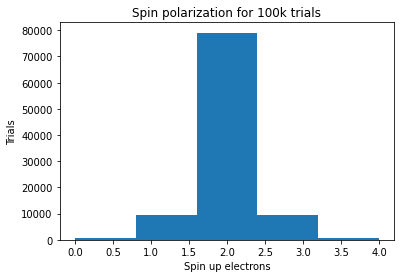

In [82]:
import matplotlib.pyplot as plt
plt.hist(total_spin_ups, bins=5)
plt.title("Spin polarization for 100k trials")
plt.xlabel("Spin up electrons")
plt.ylabel("Trials")
plt.show()
# plt.savefig("symmetric_spins.png")

Finally, let’s look at the distribution of electron spins. We know that we sometimes get a nonzero local moment, but I suspect the number of trials with spin-up and spin-down local moments will be roughly equal.

### Customizing VQE

I end up needing to rewrite most of the `SwapNetworkTrotterAnsatz` from OpenFermion to get more control over our initialization strategy. [1811.04476](https://arxiv.org/abs/1811.04476) says initial parameters turned out to be very important for reaching the ground state, and they were able to get 100% overlap on the 2x2 Hubbard model, so I'll try their strategies. 

Refer to the docstrings for more info on implementation, but broadly, the initialization strategies are: 
- Adiabatically turn on the interacting term 
- Adiabatically turn on the tunneling and interaction terms 
- Trotter expansion where all parameters are the same 
- Adiabatically turn on interaction for shorter time. 

We also try to implement the "full optimization" method outlined in [1506.05135](https://arxiv.org/abs/1506.05135). 

In [17]:
# A simple callback function we can pass into the optimizer to tell us what iteration it's on
# Nevermind: this doesn't work with study.save()
def gen_callback():
    i = 0 
    def callback(xk):
        nonlocal i
        print("Iteration: ", i)
        i += 1
    return callback

In [18]:
class CustomHubbard(SwapNetworkTrotterHubbardAnsatz):
    # Redefining my own Hubbard ansatz to override default_initial_params(self) 
    def __init__(self,
                 x_dim: float,
                 y_dim: float,
                 tunneling: float,
                 coulomb: float,
                 initial_param_method: str, # This is the only change! 
                 periodic: bool=True,
                 iterations: int=1,from 
                 adiabatic_evolution_time=None,
                 qubits=None
                 ) -> None:
        
        possible_initial_param_methods = [
            'adiabatic', 'adiabatic_tunneling', 'trotter_constant', 'adiabatic_short'
        ]
        if initial_param_method not in possible_initial_param_methods:
            raise ValueError('initial_param_method must be one of {}'.format(possible_initial_param_methods))
        self.initial_param_method = initial_param_method
        
        super().__init__(x_dim, y_dim, tunneling, coulomb, periodic=periodic, iterations=iterations, 
                         adiabatic_evolution_time=adiabatic_evolution_time, qubits=qubits)
        
    def default_initial_params(self):
        total_time = self.adiabatic_evolution_time
        step_time = total_time / self.iterations 
        
        params = [] 
        # I'm going to keep the format of the original default_initial_params (the -self.tunneling and 
        # division by pi) even though I don't understand why they do this yet. 
        if self.initial_param_method == 'adiabatic': 
            """
            Approximate evolution by H(t) = T + (t/A)V.
            Sets the parameters so that the ansatz circuit consists of a sequence
            of second-order Trotter steps approximating the dynamics of the
            time-dependent Hamiltonian H(t) = T + (t/A)V, where T is the one-body
            term and V is the two-body term of the Hamiltonian used to generate the
            ansatz circuit, and t ranges from 0 to A, where A is equal to
            `self.adibatic_evolution_time`. The number of Trotter steps
            is equal to the number of iterations in the ansatz. This choice is
            motivated by the idea of state preparation via adiabatic evolution.
            The dynamics of H(t) are approximated as follows. First, the total
            evolution time of A is split into segments of length A / r, where r
            is the number of Trotter steps. Then, each Trotter step simulates H(t)
            for a time length of A / r, where t is the midpoint of the
            corresponding time segment. As an example, suppose A is 100 and the
            ansatz has two iterations. Then the approximation is achieved with two
            Trotter steps. The first Trotter step simulates H(25) for a time length
            of 50, and the second Trotter step simulates H(75) for a time length
            of 50.

            The above docstring was copied from OpenFermion. 
            """
            for param, scale_factor in zip(self.params(),
                                           self.param_scale_factors()):
                if param.letter == 'Th' or param.letter == 'Tv':
                    params.append(_canonicalize_exponent(
                        -self.tunneling * step_time / np.pi, 4) / scale_factor)
                elif param.letter == 'V':
                    i, = param.subscripts
                    # Use the midpoint of the time segment
                    interpolation_progress = 0.5 * (2 * i + 1) / self.iterations
                    params.append(_canonicalize_exponent(
                        -0.5 * self.coulomb * interpolation_progress *
                        step_time / np.pi, 2) / scale_factor)

        elif self.initial_param_method == 'adiabatic_tunneling': 
            """
            Instead of only adiabatically turning on the interaction term, we also 
            adiabatically turn on the tunneling term. 
            
            Inspired by 1811.04476. 
            """
            for param, scale_factor in zip(self.params(),
                                           self.param_scale_factors()):
                i, = param.subscripts
                # Use the midpoint of the time segment
                interpolation_progress = 0.5 * (2 * i + 1) / self.iterations

                if param.letter == 'Th' or param.letter == 'Tv':
                    params.append(_canonicalize_exponent(
                        -self.tunneling * interpolation_progress * 
                        step_time / np.pi, 4) / scale_factor)
                elif param.letter == 'V':
                    params.append(_canonicalize_exponent(
                        -0.5 * self.coulomb * interpolation_progress *
                        step_time / np.pi, 2) / scale_factor)
        
        elif self.initial_param_method == 'trotter_constant': 
            """
            This is just Trotter decomposition for a simulation of length total_time. 
            I don't use _canonicalize_exponent(), so check what changes and if anything breaks. 
            
            Inspired by 1811.04476.
            """
            for param, scale_factor in zip(self.params(),
                                           self.param_scale_factors()):
                params.append(step_time)

        elif self.initial_param_method == 'adiabatic_short':
            """
            OpenFermion sets adiabatic_evolution_time = 0.1*abs(coulomb)*iterations, if we don't 
            provide one ourselves. This initialization method will divide that by iterations. 
            
            Inspired by 1811.04476. 
            """
            total_time /= 5
            step_time /= 5
            for param, scale_factor in zip(self.params(),  self.param_scale_factors()):
                # Copied 'adiabatic'
                if param.letter == 'Th' or param.letter == 'Tv':
                    params.append(_canonicalize_exponent(
                        -self.tunneling * step_time / np.pi, 4) / scale_factor)
                elif param.letter == 'V':
                    i, = param.subscripts
                    # Use the midpoint of the time segment
                    interpolation_progress = 0.5 * (2 * i + 1) / self.iterations
                    params.append(_canonicalize_exponent(
                        -0.5 * self.coulomb * interpolation_progress *
                        step_time / np.pi, 2) / scale_factor)
                    
        else: 
            raise ValueError("Don't know how to interpret initial parameter method {}".format(self.initial_param_method))

        return np.array(params)
    
def _canonicalize_exponent(exponent: float, period: int) -> float:
    # Shift exponent into [-p/2, +p/2).
    # They chose period = bounds (4 for T, 2 for V)
    exponent += period / 2
    exponent %= period
    exponent -= period / 2
    # Prefer (-p/2, +p/2] over [-p/2, +p/2).
    if exponent <= -period / 2:
        exponent += period  # coverage: ignore
    return exponent

SyntaxError: invalid syntax (<ipython-input-18-2da4646f5826>, line 10)

In [ ]:
from openfermioncirq import HamiltonianObjective, VariationalStudy
from openfermioncirq.optimization import ScipyOptimizationAlgorithm, OptimizationParams
from datetime import datetime

# Optimizes and saves our VariationalStudy
def run_ansatz(index_orbital_energies_combs, initialization_strat):
    steps = 10
    
    obj = HamiltonianObjective(dc_hub) # Define objective function as Hamiltonian averaging
    
#     ansatz = SwapNetworkTrotterHubbardAnsatz(x_n, y_n, 1., 2., periodic=False, iterations=steps)
    ansatz = CustomHubbard(x_n, y_n, 1., 2., initialization_strat, periodic=False, iterations=steps, 
                           adiabatic_evolution_time=50.)
    
    prep_circ = Circuit(
        prepare_gaussian_state(
            ansatz.qubits, 
            QuadraticHamiltonian(dc_hub.one_body), 
            occupied_orbitals=orbital_energies_combs[index_orbital_energies_combs]
        ))
    time = datetime.now().strftime("%m.%d.%y-%H:%M:%S")
    study = VariationalStudy(
        'Hubbard-VHA-{}-{}-{}'.format(index_orbital_energies_combs, initialization_strat, time), 
        ansatz, 
        obj, 
        preparation_circuit=prep_circ, 
        target=genergy, 
        datadir='SavedVariationalStudy'
    )
    
    algorithm = ScipyOptimizationAlgorithm(
        kwargs={'method': 'L-BFGS-B', 
#                 'tol': 1e-16
               }, 
#         options={'maxiter': 100}, 
        uses_bounds=True)
    
    optimizaton_params = OptimizationParams(algorithm=algorithm)
    
    # Optimize
    result = study.optimize(optimizaton_params)
    
    study.save()
    return result.optimal_value

In [ ]:
for i in top_three:
    for init_strat in ['adiabatic', 'adiabatic_tunneling', 'trotter_constant', 'adiabatic_short']:
        print("For tunneling ground state with index {} and initialization strategy {},the Hubbard ground state energy is {}".format(
            i, init_strat, run_ansatz(i, init_strat)))

# We don't see that much improvement...

In [ ]:
import os 
path = 'SavedVariationalStudy/' + os.listdir('SavedVariationalStudy')[1]

In [ ]:
# So once we do that optimization, we have decent overlap and we have our parameters. 
"""
It seems they do an iterated VQE: do VQE for H(1/s) using ground state of H(0), then do VQE for H(2/s) using 
ground state of H(1/s), ..., until they solve VQE for H(1). They call this the result of "sequential optimization"
and it isn't *that* close to the ground state (~70% overlap for 3 iterations with 2x2). 
Then, they used these resulting parameters as the initial parameters for an optimization method they call the 
"global vairational" method, calling this final result "full optimziation". 
Here's what the global variational method does: 
1. Choose 6 random points near the initial parameters
2. For each point, do greedy noisy search for 150 iterations: 
    a. slightly perturb point
        i. If number of acceptances in last 30 trials was large, increase step size. Else, decrease it. 
    b. keep the new value if it reduces energy
3. Do Powell on each point until convergence. 
4. Keep the point with lowest energy. 
5. Alternate greedy noisy search and Powell until neither finds improvement. 
"""

# study = VariationalStudy.load('SavedVariationalStudy/Hubbard-VHA-0-adiabatic-5.13.20-09:39:03')
study = VariationalStudy.load(path)
params = study.trial_results[0].optimal_parameters 

def init_6(params):
    """Initialize 6 'points' that we optimize. Step 1 above. """
    new_points = [] 
    for i in range(6):
        gaussian_noise = np.random.normal(size=params.size) 
        new_points.append(params + gaussian_noise)
    return new_points

def greedy_noisy_search(point, iterations=150):
    """Do greedy noisy search as described above. """
    min_point = point
    values = []
    # Standard deviation of noise - this might not work 
    step_size = 0.5
    for i in range(iterations):
        gaussian_noise = np.random.normal(scale=step_size, size=point.size)
        # Get value of new parameters
        new_val = study.value_of(point + gaussian_noise)
        values.append(new_val) 
        if new_val == min(values): 
            step_size /= 0.8 
            min_point = new_val
            print('Minimum is now {}'.format(min_point))
        elif np.random.randint(20) == 0: # Do this 1/20 times
            step_size *= 0.8
        print(i, step_size)
    return min_point

def powell(point):
    res = scipy.optimize.minimize(study.value_of, point, method='Powell', tol=1e-10)
    return res.x.real

def full_optimization(params):
    six_starter_points = init_6(params)
    for i in range(len(six_starter_points)):
        six_starter_points[i] = greedy_noisy_search(six_starter_points[i])
#         six_starter_points[i] = powell(six_starter_points[i])
        print(six_starter_points[i])
    vals = [study.value_of(point) for point in six_starter_points]
    
    try:
        best = six_starter_points[np.argmin(vals)]
        best_val = study.value_of(best)
        curr = 'greedy'
        while True: 
            old_best = best
            if curr == 'greedy':
                best = greedy_noisy_search(best)
                curr = 'powell'
            else: 
                best = powell(best)
                curr = 'greedy'
            if np.abs(study.value_of(best) - study.value_of(old_best)) < 1e-10:
                break 
    except:
        return best
    return best
            
            
full_optimization(params)
# Errors when I run Powell... but either way not seeing much improvement

In [ ]:
# So now we have an error of about 0.12. I suspect this might be the Trotter error, which means Jan-Michael's 
# decomposition will fix it. If it does, then I am justified in working on measurement precision. 
# For now, let's check the overlap with our true ground state

from cirq import resolve_parameters
from openfermioncirq.variational import variational_black_box

def get_optimal_ground_state(study): 
    # Modified variational_black_box.UNITARY_SIMULATE.evaluate_noiseless 
    black_box = study._black_box_type(
        study.ansatz, 
        study.objective, 
        study._preparation_circuit, 
        study.initial_state)
    
    circuit = resolve_parameters(
        black_box.preparation_circuit + black_box.ansatz.circuit, 
        black_box.ansatz.param_resolver(black_box.ansatz.default_initial_params()))
    final_state = circuit.final_wavefunction(
        black_box.initial_state, 
        qubit_order=black_box.ansatz.qubit_permutation(black_box.ansatz.qubits))
    return final_state

In [ ]:
# LOAD STUDY WITH BEST VALUE AND CHECK FIDELITY
study = VariationalStudy.load(path)

opt_ground = get_optimal_ground_state(study)
fidelity(opt_ground, v_hub[:,0]).real
# 97.7% fidelity is great!

How can we implement the above exponentials in a quantum circuit? Hm... 

OF has a `SwapNetworkTrotterHubbard` ansatz. How does it work? 

Well, the SwapNetwork uses only `ISWAP`, `PhasedISWAP`, `CZ` and `Z` gates. What does it do? 

It was proposed in arxiv: 1711.04789. It allows us to simulate a Trotter step in $N$ depth and $N^2 / 2$ two-qubit entangling gates, and lets us prepare arbitrary Slater determinants in $N/2$ depth, all assuming only a linearly connected architecture. 

In [ ]:
# Btw, this our ansatz
print('Created a variational study with {} qubits and {} parameters'.format(
    len(study.ansatz.qubits), study.num_params))

print("The value of the objective with default initial parameters is {}".format(
    study.value_of(ansatz.default_initial_params())))

print("The circuit of the study is:")
print(study.circuit.to_text_diagram(transpose=True))

Notice that the circuit is made up of only 2 main gates: `ISWAPPowGate` and `CZPowGate`. The Cirq documentation tells us that the matrix decomposition for these gates is: 
$$\texttt{ISWAPPowGate}(t) = \begin{bmatrix} 
1 & 0 & 0 & 0 \\ 
0 & \cos(\frac{\pi t}{2}) & i \sin \frac{\pi t}{2} & 0 \\
0 & i \sin(\frac{\pi t}{2}) & \cos(\frac{\pi t}{2}) & 0 \\
0 & 0 & 0 & 1
\end{bmatrix} \qquad \texttt{CZPowGate}(t) = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & \exp(i \pi t) 
\end{bmatrix} $$

In [ ]:
# We have 60 parameters. What are they? 
# They're in format (U/T/W/V, p, q, i) where p,q are qubits and i is iteration
# Seems 12 parameters per iteration. Per iteration, 4 interaction terms like we'd expect, 
# and then 8 tunneling terms like we'd expect. 

# How can I make these fewer? YO, SwapNetworkTrotterHubbard has only 3 parameters per iteration!
list(ansatz.params())

In [ ]:
# What does this mean?
obj.variance_bound

## Checking commutator relations of JW for Trotterization

In [ ]:
from openfermion.utils import commutator 
from openfermion.ops import FermionOperator 
from openfermion.transforms import jordan_wigner 

tunneling_01 = FermionOperator('0^ 1') + FermionOperator('1^ 0')
tunneling_12 = FermionOperator('1^ 2') + FermionOperator('2^ 1')
tunneling_23 = FermionOperator('2^ 3') + FermionOperator('3^ 2')

print('Commutator of 01 and 12 is: ', commutator(tunneling_01, tunneling_12))
print('\nJW matrix of above commutator is: ', commutator(jordan_wigner(tunneling_01), jordan_wigner(tunneling_12)))
print('\nCommutator of 01 and 23 is: ', commutator(tunneling_01, tunneling_23))
print('\nJW matrix of above commutator is: ', commutator(jordan_wigner(tunneling_01), jordan_wigner(tunneling_23)))

In [ ]:
jordan_wigner(FermionOperator('1^')) * jordan_wigner(FermionOperator('0^'))

In [ ]:
-0.25 * NKron(X, X) + 0.25 * NKron(X, Y) + 0.25 * NKron(Y, X) + 0.25 * NKron(Y, Y)

In [ ]:
hor_tun = FermionOperator('0^ 1') + FermionOperator('1^ 0') + FermionOperator('2^ 3') + FermionOperator('3^ 2')
ver_tun = FermionOperator('0^ 2') + FermionOperator('2^ 0') + FermionOperator('1^ 3') + FermionOperator('3^ 1')

In [ ]:
commutator(jordan_wigner(hor_tun), jordan_wigner(ver_tun))
# Wait so horizontal and vertical terms commute... and the individual horizontal and vertical terms commute for 
# 2x2 case. Then I should have no error at all! It's just that I need more steps... But other papers didn't need 
# more steps. I legit just have to optimize longer then?

## Trying to reduce Trotter error

The `HubbardSquareLattice` class has a useful method: `site_pair_iter(edge_type)`. We'll use the 'horizontal_neighbor' and 'vertical_neighbor' edge types. But we also need to differentiate between "even" and "odd" horizontal and vertical neighbors: even horizontal neighbors will be horizontal neighbors whose leftmost site has even index, and likewise for horizontal odd, vertical even, and vertical odd neighbors. To get this added specificity, we'll need to examine each item in the iterable generated by `site_pair_iter()`. We need the even and odd terms because then when we Trotterize the Hubbard Hamiltonian, we don't introduce any Trotter error, because the our four sets of tunneling terms (even horizontal, even vertical, odd horizontal, odd vertical) commute with each other. 

Actually, it will be much easier to just subclass `HubbardSquareLattice` and define our own `site_pair_iter()` that allows us to specify 'even' or 'odd'. I'll call this class `DecomposedHubbardSquareLattice`. 


In [ ]:
import itertools
class DecomposedHubbardSquareLattice(HubbardSquareLattice):
    @property 
    def edge_types(self):
        # Overriding edge_types property so we can define additional ones 
        return ('onsite', 'neighbor', 'diagonal_neighbor', 'horizontal_neighbor', 'vertical_neighbor', 
                'hor_even_neighbor', 'hor_odd_neighbor', 'ver_even_neighbor', 'ver_odd_neighbor')
        
    def site_pairs_iter(self, edge_type, ordered=True):
        # `ordered` parameter just flips the order: if True, for each a,b -> (a,b), (b,a); if False, for each 
        # a,b -> (a,b), so we only get it once and it doesn't flip order. 
        # We WANT ordered=False, because there's a helper function tunneling_operator(i, j, coeff) that takes in 
        # two sites i,j and does coeff*(i^j j^i). 
        
        # Overriding site_pairs_iter() to add functionality for additional edge_types 
        if edge_type == 'onsite':
            return ((i, i) for i in self.site_indices)
        elif edge_type == 'neighbor':
            return self.neighbors_iter(ordered)
        elif edge_type == 'horizontal_neighbor':
            return self.horizontal_neighbors_iter(ordered)
        elif edge_type == 'vertical_neighbor':
            return self.vertical_neighbors_iter(ordered)
        elif edge_type == 'diagonal_neighbor':
            return self.diagonal_neighbors_iter(ordered)
        # Above was copied from utils._lattice.py so we handle old edge_types correctly. 
        # Below is added functionality for new edge_types. 
        elif edge_type == 'hor_even_neighbor':
            return self.hv_eo_neighbors(lambda x,y: 1-x%2, lambda x,y: (x+1, y), ordered) 
        elif edge_type == 'hor_odd_neighbor':
            return self.hv_eo_neighbors(lambda x,y: x%2, lambda x,y: (x+1, y), ordered)
        elif edge_type == 'ver_even_neighbor':
            return self.hv_eo_neighbors(lambda x,y: 1-y%2, lambda x,y: (x, y+1), ordered)
        elif edge_type == 'ver_odd_neighbor':
            return self.hv_eo_neighbors(lambda x,y: y%2, lambda x,y: (x, y+1), ordered)
        raise ValueError('Edge type {} is not valid.'.format(edge_type))
        
    def hv_eo_neighbors(self, filter_xy, map_next_xy, ordered=True):
        for i in range(self.x_dimension):
            for j in range(self.y_dimension):
                if filter_xy(i, j):
                    # Get indices for next site  
                    k, l = map_next_xy(i, j)
                    # Make sure next site isn't out of bounds 
                    if k >= self.x_dimension or l >= self.y_dimension: continue 
                    
                    site_a = self.to_site_index((i, j))
                    site_b = self.to_site_index((k, l))
                    
                    yield (site_a, site_b)
                    if ordered: yield (site_b, site_a)
        
    # Function OpenFermion uses for 'horizontal_neightbor' edge_type.  
    # PROBLEM: This loops around! Notice the % self.x_dimension. 
    def horizontal_neighbors_iter(self, ordered=True):
        n_horizontal_edges_per_y = (
            self.x_dimension - (self.x_dimension <= 2 or not self.periodic))
        for x in range(n_horizontal_edges_per_y):
            for y in range(self.y_dimension):
                i = self.to_site_index((x, y))
                j = self.to_site_index(((x + 1) % self.x_dimension, y))
                yield (i, j)
                if ordered:
                    yield (j, i)

    # Function OpenFermion uses for 'vertical_neighbor' edge_type
    def vertical_neighbors_iter(self, ordered=True):
        n_vertical_edges_per_x = (self.y_dimension -
                                  (self.y_dimension <= 2 or not self.periodic))
        for y in range(n_vertical_edges_per_x):
            for x in range(self.x_dimension):
                i = self.to_site_index((x, y))
                j = self.to_site_index((x, (y + 1) % self.y_dimension))
                yield (i, j)
                if ordered:
                    yield (j, i)
    
    # I'm changing this function so that it uses my functions, so I can compare the spectrums, since 
    # FermiHubbardModel.hamiltonian() will call this to generate the iterable. 
    def neighbors_iter(self, ordered=True):
        return itertools.chain(
            #self.horizontal_neighbors_iter(ordered),
            #self.vertical_neighbors_iter(ordered)
            
            # itertools.chain('ABC', 'DEF') = Iterable('ABCDEF') 
            self.site_pairs_iter('hor_even_neighbor', ordered), 
            self.site_pairs_iter('hor_odd_neighbor', ordered), 
            self.site_pairs_iter('ver_even_neighbor', ordered), 
            self.site_pairs_iter('ver_odd_neighbor', ordered), 
        )


lattice = DecomposedHubbardSquareLattice(x_n, y_n, n_dofs=n_dofs, periodic=periodic, spinless=spinless)
hubbard = FermiHubbardModel(lattice , tunneling_parameters=tunneling, interaction_parameters=interaction, 
                            potential_parameters=potential, magnetic_field=mag_field, 
                            particle_hole_symmetry=particle_hole_sym)

In [ ]:
from openfermion.ops import FermionOperator

def tunneling_operator(i, j, coefficient=1.):
    # Copied from hamiltonians/_lattice.py in OpenFermion
    return (FermionOperator(((i, 1), (j, 0)), coefficient) + FermionOperator(
        ((j, 1), (i, 0)), coefficient.conjugate()))
def tunneling_terms_hor_even(hor, even, model):
    # Mostly copied from FermiHubbardMode.tunneling_terms() 
    terms = FermionOperator()
    for param in model.tunneling_parameters:
        a, aa = param.dofs 
        # We don't use param.edge_type because it's 'neighbor' and we need to be more specific
        if hor and even:
            site_pairs = model.lattice.site_pairs_iter('hor_even_neighbor', a != aa)
        elif hor and not even: 
            site_pairs = model.lattice.site_pairs_iter('hor_odd_neighbor', a != aa)
        elif not hor and even: 
            site_pairs = model.lattice.site_pairs_iter('ver_even_neighbor', a != aa)
        elif not hor and not even:
            site_pairs = model.lattice.site_pairs_iter('ver_odd_neighbor', a != aa)

        for r, rr in site_pairs: 
            for spin_index in model.lattice.spin_indices:
                i = model.lattice.to_spin_orbital_index(r, a, spin_index)
                j = model.lattice.to_spin_orbital_index(rr, aa, spin_index)
                terms += tunneling_operator(i, j, -param.coefficient)
    return terms

In [ ]:
hamiltonians = {
    'hub': hubbard.hamiltonian(), 
    'non_interacting': hubbard.tunneling_terms(), 
    'hor_even': tunneling_terms_hor_even(True, True, hubbard), 
    'hor_odd': tunneling_terms_hor_even(True, False, hubbard), 
    'ver_even': tunneling_terms_hor_even(False, True, hubbard), 
    'ver_odd': tunneling_terms_hor_even(False, False, hubbard)
}

In [ ]:
# Check to make sure summing up the parts gives us the whole of non_interacting term 
print('Sum of horizontal/vertical even/odd terms gives non-interacting term: ', 
      (hamiltonians['hor_even'] + hamiltonians['hor_odd'] + hamiltonians['ver_even'] + 
       hamiltonians['ver_odd'] == hamiltonians['non_interacting']))

## Analyzing ground states of tunneling term

In [ ]:
# Recall we calculated w_tun and v_tun as the 16 degenerate lowest eigenvalues and eigenvectors of the 
# tunneling term
v_tun.shape

In [ ]:
v_tun[:,0][3]

In [ ]:
tol = 1e-5
def decompose_HF(state):
    """Decomposes an eigenstate (I can generalize to any state later) as a tensor product of |0> and |1> """
    tot = 0
    for i in range(len(state)):
        if np.abs(state[i]) > tol:
            tot += 1
    return tot
        


# Why do they all have 196 nonzero coefficients?
for j in range(16):
    print(decompose_HF(v_tun[:,j]))

Oh, right, I guess the ground state *doesn't have to be* a pure state in the computational basis. It has to first and foremost be an eigenvector. For the Hadamard matrix, the eigenvectors are $\ket{+}$ and $\ket{-}$, where $\ket{-}$ is the ground state, for example. 

Okay, so I need to move this to a basis where the Hamiltonian is diagonal. That's just the Bogoliubov transform. Then each eigenvector should be a separate basis state. Before I do that, let's just verify that the 16 degenerate eigenvectors are orthogonal. 

In [ ]:
def check_orthogonal(m):
    """Checks that each vector m[:,i] is orthogonal to the other vectors in m"""
    for i in range(m.shape[1]):
        vec1 = m[:,i]
        for j in range(i+1, m.shape[1]):
            vec2 = m[:,j]
            overlap = fidelity(vec1, vec2)
            assert np.abs(overlap) < tol, "Inner product was {} for vectors {} and {}.".format(overlap, i, j)
            
check_orthogonal(v_tun)

Right, the eigenvectors of a Hermitian matrix are orthogonal if the eigenvalues are distinct. All these vectors have the same eigenvalues, so the eigenvectors don't have to be orthogonal. 

Well, we could make them orthogonal with Gram-Schmidt, but wouldn't that change the eigenvalues? No, consider
$$ H ( \ket{\psi_0} + \ket{\psi_1} ) = E_1 \ket{\psi_0} + ? \ket{\psi_1} $$
where $\ket{\psi_0}$ is the first eigenvector, and we decomposed the second eigenvector as $\ket{\psi_0} + \ket{\psi_1}$. Then, by definition of eigenvector, the eigenvalue of $\ket{\psi_1}$ must be $E_1$. So, Gram-Schmidt preserves eigenvalues. 

Simple enough, I'll do GS on the degenerate ground states. Fine, but then what? After the Bogoliubov transform, the eigenvectors no longer represent distinct pure states in HF space. So how can I analyze this?

In [ ]:
# Hubbard ground state is a superposition of 16 HF states
decompose_HF(v_hub)

For 2 x 1 lattice, `v_hub` is a superposition of 4 states, and for a 2 x 2 lattice, `v_hub` is a superposition for 16 states. I'm guessing it's a function $2^{\mathrm{\# sites}}$, but why? 

Hypothesis 1: up and down spins are symmetric here since we don't really have different behavior for them. So, suppose the ground state is defined for $x$ fermions where $x = N / 2$, ie half-filling. The $2^x$ occurs because we can choose to put each fermion in either UP spin or DOWN spin, without changing the energy of the system. 